# Práctica 5

In [429]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Ejercicio 1: Regresión lineal regularizada

In [430]:
mat = loadmat('ex5data1.mat')
X = mat.get("X")
y = mat.get("y")
Xval = mat.get("Xval")
yval = mat.get("yval")

print(X.shape, y.shape)
print(Xval.shape, yval.shape)
print(np.mean(X), np.std(X))
print(np.mean(y), np.std(y))

(12, 1) (12, 1)
(21, 1) (21, 1)
-5.085426348834809 28.68873075847896
11.217589325366376 12.492955274415026


In [431]:
def coste_vec(Theta, X, y):   
    # añadimos una columna de 1's a la X
    m = np.shape(X)[0]
   # X = np.hstack([np.ones([m, 1]), X])
    H = np.dot(X, Theta)
    Aux = (H - y) ** 2
    return Aux.sum() / (2 * len(X))

In [432]:
def coste_reg(Theta, X, y, Lambda):
    Theta = Theta.reshape((Theta.shape[0],1))
    Term1 = coste_vec(Theta, X, y)
    Term2 = (Lambda/(2*len(y))) * np.sum(Theta**2)
    cost = Term1 + Term2
    return cost 

In [433]:
def gradiente_vec(Theta, X, Y):
    m = np.shape(X)[0]
    H = np.dot(X, Theta)
    Aux = (H - Y)
    grad = np.dot(Aux.T, X) * (1/m)
    return grad

In [434]:
def gradiente_reg(Theta, X, Y, Lambda):
    Theta = Theta.reshape((Theta.shape[0],1))
    item1 = gradiente_vec(Theta, X, Y).T
    item2  = (Lambda/len(y))*np.r_[[np.zeros(Theta.shape[1])], Theta[1:]]
    #item2  = (Lambda/len(y))*np.r_[[0], Theta[1:]]
    grad = item1 + item2
    grad = grad.flatten()
    return grad

In [435]:
def coste_grad_reg(Theta, X, Y, Lambda):
    coste = coste_reg(Theta, X, y, Lambda)
    grad = gradiente_reg(Theta, X, Y, Lambda)
    return coste, grad

In [436]:
theta = np.ones((2,1))
#theta = np.ones(2)
m=len(y)
X_1 = np.hstack([np.ones([m, 1]), X])
coste, grad = coste_grad_reg(theta, X_1, y, 1)
print(coste, grad)

304.0348588869309 [-15.30301567 598.25074417]


In [437]:
Lambda = 0
theta = np.ones((2,1))
result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_1,y,Lambda))
Theta_opt=result[0]
coste_opt = coste_reg(Theta_opt, X_1, y, Lambda)
print('Coste = {}'.format(coste_opt))

Coste = 22.373906495108997


In [438]:
print(Theta_opt.shape)

(2,)


In [439]:
def plot_H(X, Y, theta):
    plt.plot(X, Y, "x")
    theta0 = theta[0]
    theta1 = theta[1]
    min_x = min(X)
    max_x = max(X)
    min_y = theta0 + theta1 * min_x
    max_y = theta0 + theta1 * max_x
    plt.plot([min_x, max_x], [min_y, max_y])
    plt.savefig("resultado.pdf")

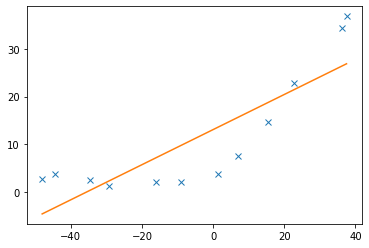

In [440]:
plot_H(X, y, Theta_opt)

## Ejercicio 2: Curvas de aprendizaje

In [441]:
def curva_aprendizaje(theta, X, y, Lambda):
    m = len(y)
    X_1 = np.hstack([np.ones([m, 1]), X])
    muestras, J_train, J_val = [], [], []
    for i in range(1, 11, 1):
        X_train_aux = X_1[:i, :]
        y_train_aux = y[:i]
        result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_train_aux,y_train_aux,Lambda))
        theta_aux = result[0]
        J_train.append(coste_reg(theta_aux,X_train_aux,y_train_aux,Lambda))
        J_val.append(coste_reg(theta_aux, X_1, y,Lambda))
        muestras.append(y_train_aux.shape[0])
    return muestras, J_train, J_val

In [442]:
def plot_curva(muestras, J_train, J_val):
    plt.figure()
    plt.plot(muestras, J_train, label='Train')
    plt.plot(muestras, J_val, label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.show()

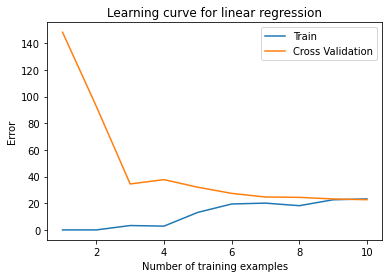

In [443]:
muestras, J_train, J_val = curva_aprendizaje(theta, X, y, 0)
plot_curva(muestras, J_train, J_val)

## Ejercicio 3: Regresión polinomial

In [444]:
def expand_X(X, p):
    m=X.shape[0]
    X_p = np.zeros((m,p))
    for i in range(p):
        dim = i+1
        X_p[:, i] = X[:, 0] ** (i + 1)
 
    return X_p
    

In [445]:
X_8 = expand_X(X,8)

In [446]:
print(X)

[[-15.93675813]
 [-29.15297922]
 [ 36.18954863]
 [ 37.49218733]
 [-48.05882945]
 [ -8.94145794]
 [ 15.30779289]
 [-34.70626581]
 [  1.38915437]
 [-44.38375985]
 [  7.01350208]
 [ 22.76274892]]


In [447]:
print(X_8)
print(X_8.shape)

[[-1.59367581e+01  2.53980260e+02 -4.04762197e+03  6.45059724e+04
  -1.02801608e+06  1.63832436e+07 -2.61095791e+08  4.16102047e+09]
 [-2.91529792e+01  8.49896197e+02 -2.47770062e+04  7.22323546e+05
  -2.10578833e+07  6.13900035e+08 -1.78970150e+10  5.21751305e+11]
 [ 3.61895486e+01  1.30968343e+03  4.73968522e+04  1.71527069e+06
   6.20748719e+07  2.24646160e+09  8.12984311e+10  2.94215353e+12]
 [ 3.74921873e+01  1.40566411e+03  5.27014222e+04  1.97589159e+06
   7.40804977e+07  2.77743990e+09  1.04132297e+11  3.90414759e+12]
 [-4.80588295e+01  2.30965109e+03 -1.10999128e+05  5.33448815e+06
  -2.56369256e+08  1.23208064e+10 -5.92123532e+11  2.84567638e+13]
 [-8.94145794e+00  7.99496701e+01 -7.14866612e+02  6.39194974e+03
  -5.71533498e+04  5.11034273e+05 -4.56939146e+06  4.08570215e+07]
 [ 1.53077929e+01  2.34328523e+02  3.58705250e+03  5.49098568e+04
   8.40548715e+05  1.28669456e+07  1.96964539e+08  3.01509237e+09]
 [-3.47062658e+01  1.20452489e+03 -4.18045609e+04  1.45088020e+06
  -

In [448]:
def normalizer(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

In [449]:
X_8_norm, mu, sigma = normalizer(X_8)
print(X_8_norm)
print(X_8_norm.shape)

[[-3.78243704e-01 -7.88662325e-01  1.90328720e-01 -7.37591303e-01
   3.20251970e-01 -6.17151602e-01  3.59835014e-01 -5.31091256e-01]
 [-8.38920100e-01  1.31420204e-03 -2.58961742e-01 -3.41564822e-01
   9.75492734e-02 -4.55196644e-01  2.66773432e-01 -4.68873807e-01]
 [ 1.43871736e+00  6.10831582e-01  1.30534069e+00  2.56220001e-01
   1.02186338e+00 -1.26962121e-02  7.90210009e-01 -1.77926980e-01]
 [ 1.48412330e+00  7.38068463e-01  1.42031240e+00  4.13121830e-01
   1.15534830e+00  1.31223708e-01  9.10700224e-01 -6.22895388e-02]
 [-1.49791929e+00  1.93643966e+00 -2.12774745e+00  2.43510061e+00
  -2.51876748e+00  2.71792174e+00 -2.76331690e+00  2.88908182e+00]
 [-1.34409278e-01 -1.01936614e+00  2.62563148e-01 -7.72577738e-01
   3.31046537e-01 -6.21453712e-01  3.61188658e-01 -5.31586524e-01]
 [ 7.10844248e-01 -8.14713668e-01  3.55803314e-01 -7.43368461e-01
   3.41027665e-01 -6.18104683e-01  3.62252117e-01 -5.31229003e-01]
 [-1.03249041e+00  4.71428060e-01 -6.28018432e-01  9.70487696e-02
  -

In [450]:
print(mu)
print(mu.shape)

print(sigma)
print(sigma.shape)

[-5.08542635e+00  8.48904834e+02 -1.28290173e+04  1.28967789e+06
 -2.98314592e+07  2.29330301e+09 -6.84527284e+10  4.42233759e+12]
(8,)
[2.86887308e+01 7.54346385e+02 4.61380464e+04 1.66104441e+06
 8.99399404e+07 3.68940106e+09 1.89508052e+11 8.31905350e+12]
(8,)


In [451]:
#Añadimos columna de 1's a los datos de entrenamiento X_8_norm
m = X_8_norm.shape[0]
X_1 = np.hstack([np.ones([m, 1]), X_8_norm])

In [452]:
Lambda = 0
theta = np.ones((9,1))
result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_1,y,Lambda))
Theta_opt=result[0]
coste_opt = coste_reg(Theta_opt, X_1, y, Lambda)
print('Coste = {}'.format(coste_opt))

Coste = 0.06485124464273889


In [453]:
print(Theta_opt)

[ 11.21658794   9.9749428   17.63735909  17.63007793 -28.08352897
 -34.41211389  25.4851335   21.81646982  -6.04467905]


In [454]:
def plot_poli(X, y, theta, mu, sigma):
    plt.plot(X, y, "x")
    
    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    xx1 = np.linspace(x1_min, x1_max)
    
    xx1=xx1.reshape((xx1.shape[0],1))
    
    theta=theta.reshape((theta.shape[0],1))
    
    X_8 = expand_X(xx1,8)
    
    X_8_norm = (X_8 - mu)/sigma
    X_8_norm_1 = np.hstack([np.ones([X_8_norm.shape[0], 1]), X_8_norm])

    
    h=0
    h = np.matmul(X_8_norm_1,theta)
        # 50x8 x 8, -> 50x1 -> 50,

    plt.plot(xx1, h)  
    plt.title('Polynomial regression (lambda = 0)')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water lowing out of the dam (y)')
    plt.show()


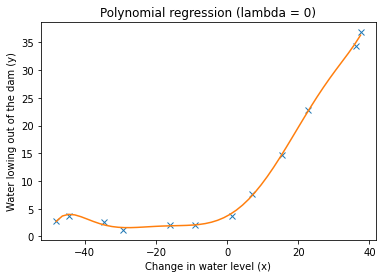

In [455]:
plot_poli(X, y, Theta_opt, mu, sigma)

In [462]:
def curva_aprendizaje_poli(theta, X, y, Lambda, sigma, mu):
    m = len(y)
    X_1 = np.hstack([np.ones([m, 1]), X])
    muestras, J_train, J_val = [], [], []
    for i in range(1, 13, 1):
        X_train_aux = X_1[:i, :]
        y_train_aux = y[:i]
        X_8 = expand_X(X_train_aux,8)
        X_train_aux = ((X_8 - mu)/sigma).T
        
        result = opt.fmin_tnc(func=coste_reg, x0=theta, fprime=gradiente_reg, args=(X_train_aux,y_train_aux,Lambda))
        theta_aux = result[0]
        J_train.append(coste_reg(theta_aux,X_train_aux,y_train_aux,Lambda))
        J_val.append(coste_reg(theta_aux, X_1, y,Lambda))
        muestras.append(y_train_aux.shape[0])
    return muestras, J_train, J_val

In [463]:
theta = np.ones((2,1))
muestras, J_train, J_val = curva_aprendizaje_poli(theta, X, y, 0, sigma, mu)
plot_curva(muestras, J_train, J_val)

ValueError: shapes (8,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)